In [41]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from numpy import savetxt

In [49]:
class particle:
    """class that define a particle"""
    def __init__(self, n_atom, rads_atom, size = 10):
        self.n_atom = n_atom
        self.rads_atom = rads_atom
        self.size = size
        self.crds = size * np.random.rand(n_atom, 3)
        self.crds -= np.mean(self.crds, axis=0)
        self.rads = rads_atom
        self.image = None
        self.size_grid = 32
        self.size_image = 25
        
    def rotate(self, random = True, quat = None):
        """
        Rotating the particle with the quaternion notation
        """
        if random:
            rotation =  R.random()
        else:
            rotation = R.from_quat(quat)
            
        for i in range(self.n_atom):
            self.crds[i] = rotation.apply(self.crds[i])
            
        self.create_image()
    
    def create_image(self):
        """
        Return the projection of the particle along the z axis
        """
        image = np.zeros((self.size_grid,self.size_grid))
        for i in range(self.size_grid):
            for j in range(self.size_grid):
                posx = -self.size_image/2 + i*self.size_image/(self.size_grid-1)
                posy = -self.size_image/2 + j*self.size_image/(self.size_grid-1)
                
                for iat in range(self.n_atom):
                    dx = self.crds[iat,0] - posx
                    dy = self.crds[iat,1] - posy
                    dist2 = dx*dx + dy*dy
                    if dist2 <= 100:
                        #integrating along z axis
                        image[i,j] += np.sqrt(np.pi)*np.exp(-0.5*dist2/self.rads[iat]**2)
                        
        self.image = image
    
    def show(self):
        if self.has_image:
            plt.imshow(self.image, cmap='Greys')            

In [62]:
def generate_dataset(particle, length):
    
    dataset = np.zeros((length, particle.size_grid, particle.size_grid))
    for i in range(length):
        particle.rotate()
        dataset[i] = particle.image
        
        if (i+1)%100 == 0:
            print(str(i+1) + ' images were created')
    # save to csv file
    filename = 'dataset ' + str(particle.n_atom) + ' atoms (' + str(length) + ' images)'
    np.save(filename, dataset)
    
    

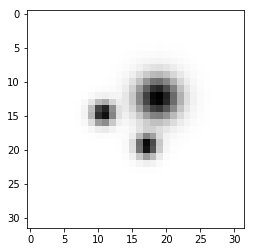

In [35]:
a = particle()

In [63]:
#test
particle_ = particle(3, [1,2,1])
generate_dataset(particle_,1000)

100 images were created
200 images were created
300 images were created
400 images were created
500 images were created
600 images were created
700 images were created
800 images were created
900 images were created
1000 images were created


In [64]:
dataset = np.load('dataset 3 atoms (1000 images).npy')

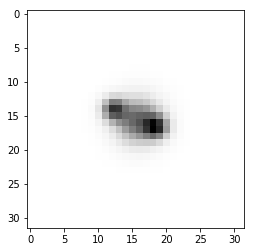

In [73]:
plt.imshow(dataset[5], cmap ='Greys')